In [6]:
import pandas as pd
import numpy as np
import os
import importlib.util
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

# Get the absolute path to your local evaluate.py
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
evaluate_path = os.path.join(project_root, 'evaluate.py')

# Dynamically load evaluate_model from evaluate.py
spec = importlib.util.spec_from_file_location("evaluate", evaluate_path)
evaluate_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(evaluate_module)
evaluate_model = evaluate_module.evaluate_model

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
data_path = os.path.join(project_root, "data", "cleaned_crime_data_stratified.csv")
# Load data
df = pd.read_csv(data_path)
X = df.drop('crime_code', axis=1)
y = df['crime_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

base_learners = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
]
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

In [7]:
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

In [8]:
# Hyperparameter grid
param_grid = {
    'rf__n_estimators': [100],
    'rf__max_depth': [None],
    'svc__C': [1],
    'svc__gamma': ['scale']
}

# Train with GridSearch
grid_search = GridSearchCV(stack_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

In [9]:
# === Evaluate predictions ===
save_dir = os.path.join(project_root, "stacking_results")
evaluate_model(
    eval_y=y_test,
    pred_y=y_pred,
    model_name="stacking_classifier",
    best_params=grid_search.best_params_,
    save_path=save_dir
)

Model: stacking_classifier
Accuracy: 0.6685
Precision (weighted): 0.6687
Recall (weighted): 0.6685
F1 Score (weighted): 0.6666

Best Hyperparameters:
{'rf__max_depth': None, 'rf__n_estimators': 100, 'svc__C': 1, 'svc__gamma': 'scale'}

Confusion matrix plot saved to: C:\Users\DavidD\anaconda_projects\ML-Project-main\ML-Project-main\stacking_results\stacking_classifier_confusion_matrix.png
Performance report saved to: C:\Users\DavidD\anaconda_projects\ML-Project-main\ML-Project-main\stacking_results\stacking_classifier_performance_report.txt


0.6665800903189647


Confusion Matrix:


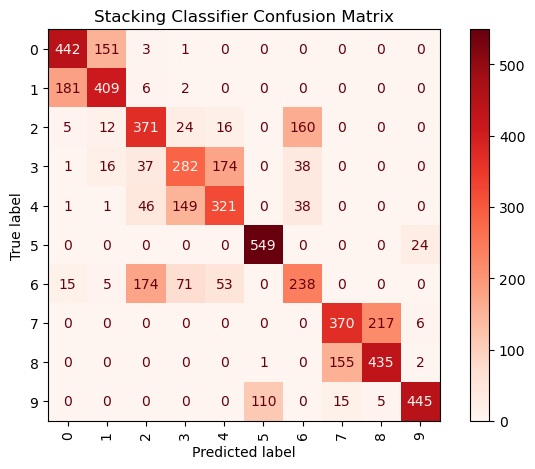

In [10]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display using the best estimator's predicted class labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=grid_search.best_estimator_.classes_  # classes auto-fetched from model
)

print("\nConfusion Matrix:")
disp.plot(xticks_rotation='vertical', cmap='Reds')
plt.title("Stacking Classifier Confusion Matrix")
plt.tight_layout()
plt.show()